In [4]:
from __future__ import division
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
import statsmodels.api as sm
import scipy

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 0. Data Preparation

## 0.1. Read and Clean Data

In [5]:
df = pd.read_csv("prc.csv")  # TBA price
FN_issue = pd.read_csv("FN_issuance.csv")  # issuance 
rr_daily = pd.read_excel("ILM3NAVG_daily.xlsx") # Use Bankrate.com US Home Mortgage 30year Fixed Natinal Avg
TR_10 = pd.read_excel("USGG10YR.xlsx")
CMMFIX=pd.read_excel("CMMFIX.xlsx",skiprows = 6) # treasury rate approxy
CMMFIX.sort_values(by='Date', axis=0, ascending=True,inplace=True) 
CMMFIX = CMMFIX.reset_index(drop=True)
MTGFNCL=pd.read_excel("MTGEFNCL.xlsx",skiprows = 5) # treasury rate approxy
MTGFNCL.sort_values(by='Date', axis=0, ascending=True,inplace=True) 
MTGFNCL = MTGFNCL.reset_index(drop=True)

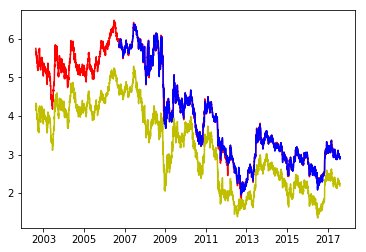

In [6]:
rate_base=pd.DataFrame(MTGFNCL.merge(CMMFIX,how='left', on="Date"),columns = ['Date','PX_LAST_x','PX_LAST_y'])
rate_Base=pd.DataFrame(rate_base.merge(TR_10,how='left', on="Date"),columns = ['Date','PX_LAST_x','PX_LAST_y','PX_LAST'])
rate_Base=rate_Base.rename(columns={'PX_LAST_x': 'MTGFNCL', 'PX_LAST_y': 'CMMFIX','PX_LAST': 'TR'})
plt.plot(rate_Base['Date'].values,rate_Base['MTGFNCL'].values,c='r')
plt.plot(rate_Base['Date'].values,rate_Base['CMMFIX'].values,c='b')
plt.plot(rate_Base['Date'].values,rate_Base['TR'].values,c='y')
plt.show()

From the above graph, we can conclude that MTGFNCL and CMMFIX are almost the same. Given the availiability of CMMFIX, we choose the MTGFNCL as the treasury rate approxy.

In [7]:
rate_Base=rate_Base.loc[:,'Date':'MTGFNCL']
rate_Base.set_index('Date', inplace = True)
coupon_rates=df['coupon'].unique()
coupon_rates.sort()
df['Date']=pd.to_datetime(df['date'], format='%Y%m%d')
df.set_index('Date', inplace = True)
df=df.drop('date',axis=1)

In [8]:
TBAs = {}
for i in np.arange(0, len(coupon_rates)):
    TBAs[coupon_rates[i]] = df.ix[(df['coupon']==coupon_rates[i])].dropna()
    TBAs[coupon_rates[i]] = pd.concat([TBAs[coupon_rates[i]], rate_Base], axis=1, join='inner')
    TBAs[coupon_rates[i]]['Spread']  = coupon_rates[i] - TBAs[coupon_rates[i]]['MTGFNCL']
    TBAs[coupon_rates[i]]['Year'] = TBAs[coupon_rates[i]].index.year


Finding the most issue coupon 

In [9]:
FN_issue.set_index('Date', inplace = True)
rr_daily.set_index('Date', inplace = True)
rr_daily.columns = ['Last rate', 'Mid rate']
TR_10.set_index('Date', inplace = True)
TR_10.columns = ['10 year rate']

For each month find the max issuance bond and use this to generate the price and yield relation

In [10]:
Most_issue = []
Second_Most_issued = []
Third_Most_issued = []
for i in FN_issue.index:
    tmp = FN_issue.loc[i]
    fst_max = np.argmax(tmp)
    tmp = tmp.drop(fst_max)
    sec_max = np.argmax(tmp)
    tmp = tmp.drop(sec_max)
    trd_max = np.argmax(tmp)
    Most_issue.append(float(fst_max.split()[4][:-1]))
    Second_Most_issued.append(float(sec_max.split()[4][:-1]))
    Third_Most_issued.append(float(trd_max.split()[4][:-1]))

Plot the monthly most issued coupon rate vs. reference rate

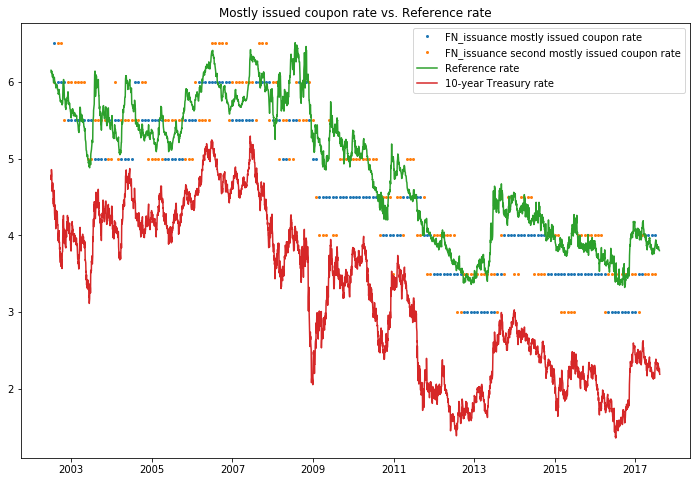

In [11]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot_date(FN_issue.index, Most_issue, label = 'FN_issuance mostly issued coupon rate', markersize = 2)
ax.plot_date(FN_issue.index, Second_Most_issued, label = 'FN_issuance second mostly issued coupon rate', markersize = 2)
#ax.plot_date(FN_issue.index, Third_Most_issued, label = 'FN_issuance Third mostly issued coupon rate', markersize = 2)
ax.plot_date(rr_daily.index,rr_daily['Mid rate'],'-',label = 'Reference rate')
ax.plot_date(TR_10.index, TR_10['10 year rate'],'-',label = '10-year Treasury rate')
ax.set_title("Mostly issued coupon rate vs. Reference rate")
ax.legend()

From graph above, we would like to use same coupon for regression as long as possible.
In general, there is a rate drop from 6% to 3%. We then cut the entire time frame into three parts.
First part from begin to about late 2008, use coupon 5.5% as representative.
Second part, we use coupon 4.5% for the middle part of our time series.
Final part, the low rate part, we would like to use 3.5%
The detailed cutoff time will be determined in the next cell.

TBA data to use in each time period. Pick the TBA data with coupon = mostly issued coupon rate at each time point

In [12]:
First_Part_5_5 = TBAs[5.5][:'2008-11-27']
Second_Part_4_5 = TBAs[4.5]['2008-11-28':'2011-12-31']
Third_Part_3_5 = TBAs[3.5]['2012-01-01':]

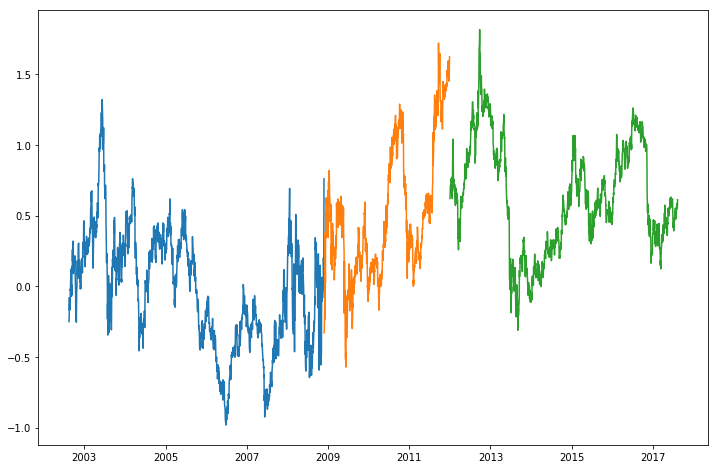

In [13]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(First_Part_5_5.index, First_Part_5_5['Spread'], label = 'FN_issuance mostly issued coupon rate', markersize = 2)
ax.plot(Second_Part_4_5.index, Second_Part_4_5['Spread'], label = 'FN_issuance mostly issued coupon rate', markersize = 2)
ax.plot(Third_Part_3_5.index, Third_Part_3_5['Spread'], label = 'FN_issuance mostly issued coupon rate', markersize = 2)

## 0.2. Data Exploration

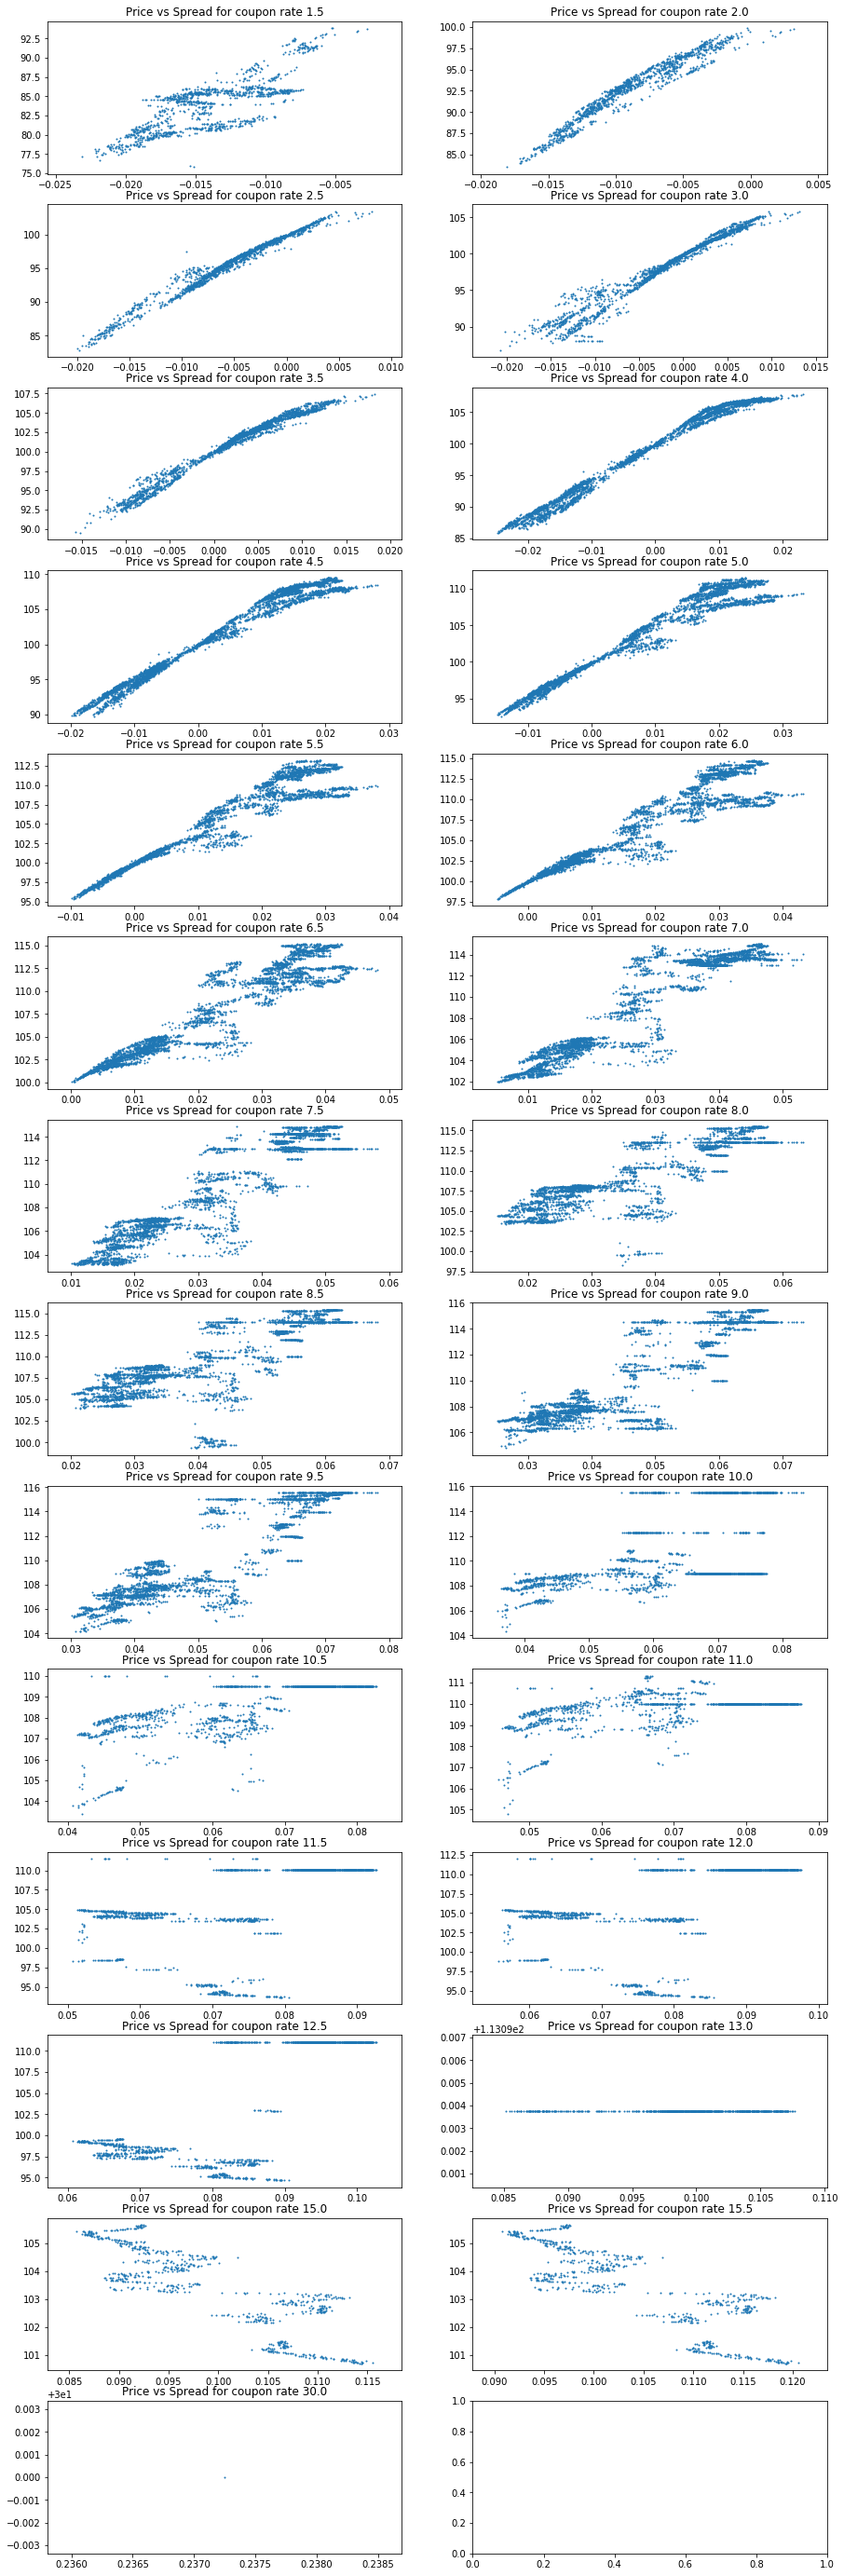

In [14]:
f, axarr = plt.subplots(14, 2,figsize=(15,50))
i = 0
j = 0
for k in np.arange(len(coupon_rates)):
    data = TBAs[coupon_rates[k]]
    axarr[i, j].scatter(data['Spread'].values / 100, data['price'].values,s=1)
    axarr[i, j].set_title('Price vs Spread for coupon rate ' + str(coupon_rates[k]))
    i = i + j
    j = 1 - j

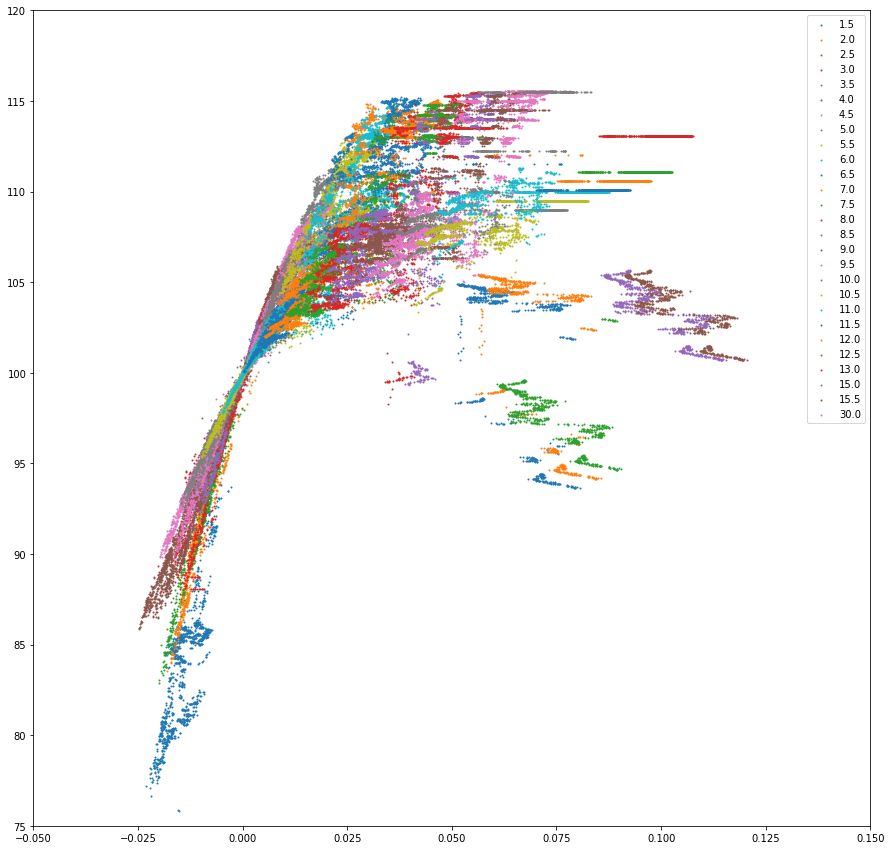

In [15]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
for k in np.arange(len(coupon_rates)):
    data = TBAs[coupon_rates[k]]
    ax.scatter(data['Spread'].values / 100, data['price'].values,s=1, label = str(coupon_rates[k]))
ax.set_xlim([-0.05,0.15])
ax.set_ylim([75,120])
plt.legend()

In [16]:
x=np.diff(data['price'].values)
y=np.diff(data['Spread'].values / 100)

In [17]:
use = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]
params = {}
n = 5
for i in use:
    indexes = TBAs[i].index[n:]
    ret = np.diff(TBAs[i]['price'].values,n)/TBAs[i]['price'].values[:-n]
    params[i] = pd.DataFrame({'Date':indexes, 'Return':ret})
    params[i].set_index('Date', inplace = True)
    params[i]['Rate Change'] = np.diff(TBAs[i]['Spread'].values / 100,n)
    
    
#print(params[2.5])


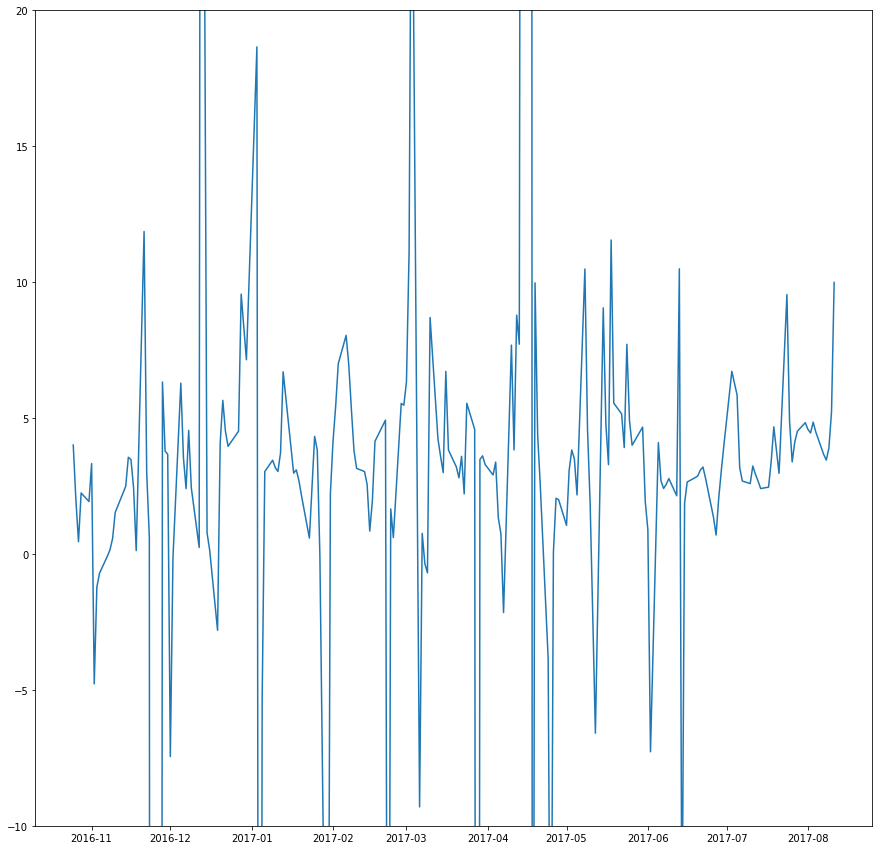

In [18]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
k = 4
#for k in np.arange(len(use)):
data = params[use[k]]
#ax.scatter(data['Rate Change'].values[:120], data['Return'].values[:120],s=1, label = str(use[k]))
ax.plot(data['Rate Change'].index[-200:],data['Return'].values[-200:] / data['Rate Change'].values[-200:])

#ax.set_xlim([-0.05,0.15])
ax.set_ylim([-10,20])
plt.legend()

## 0.3. Logistic Regression

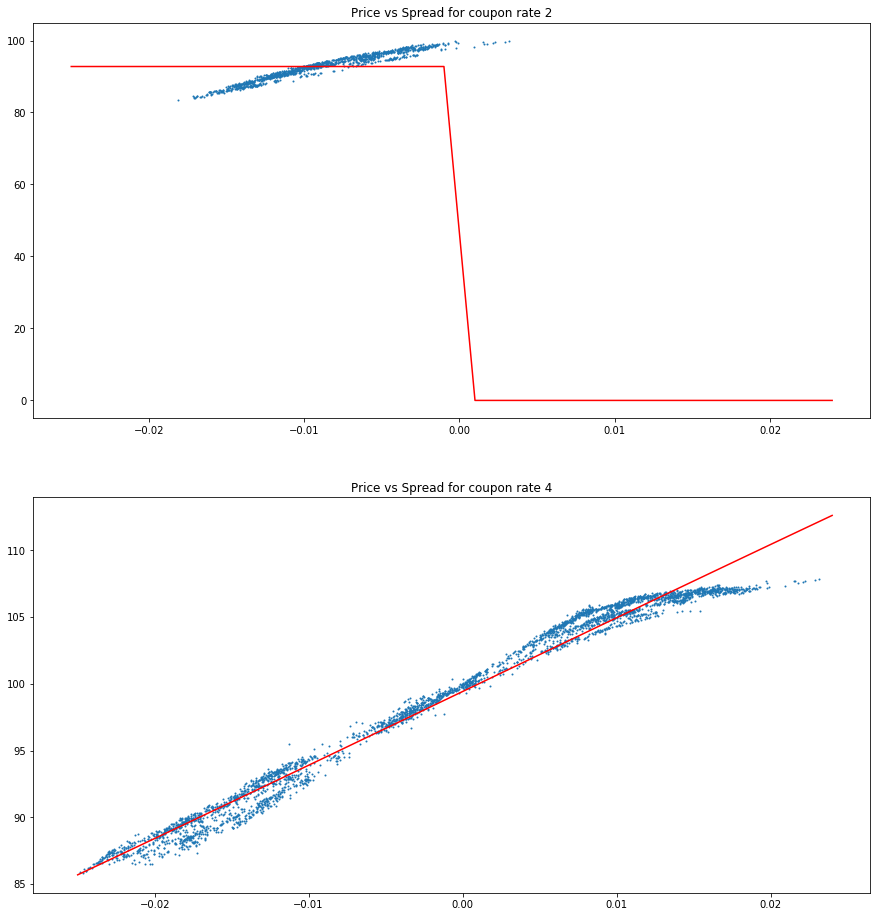

In [19]:
coupon=[2,4]

plt.figure(figsize=(15,8*len(coupon)))  
for k,c in enumerate(coupon):
    data = TBAs[c]
    plt.subplot(len(coupon),1,k+1)
    plt.scatter(data['Spread'].values / 100, data['price'].values,s=1)
    plt.title('Price vs Spread for coupon rate ' + str(c))
    
    fit, b = scipy.optimize.curve_fit(lambda t,a,b: a/(1+np.exp(-b*(t-0))),  data['Spread'].values / 100,  data['price'].values)
    a, b = fit[0], fit[1]
    x=np.arange(-0.025,0.025,0.001)
    plt.plot(x,a/(1+np.exp(-b*(x-0))),color='r')

## 0.4. Micharealis Menten Model

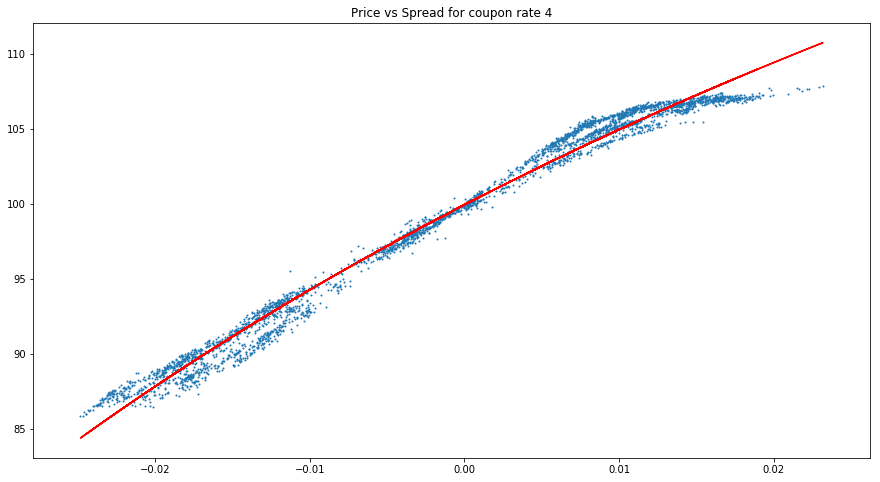

In [20]:
coupon=[4]

plt.figure(figsize=(15,8*len(coupon)))  
for k,c in enumerate(coupon):
    x=data['Spread'].values / 100
    shift=np.min(x)
    x=x-shift
    y=data['price'].values
    data = TBAs[c]
    plt.subplot(len(coupon),1,k+1)
    plt.scatter(x+shift, y,s=1)
    plt.title('Price vs Spread for coupon rate ' + str(c))
    
    fit, b = scipy.optimize.curve_fit(lambda t,a,b,c: a*t/(b+t)+c, x,  y)
    a, b , c= fit[0], fit[1], fit[2]
    plt.plot(x+shift,a*x/(b+x)+c,color='r')

## 0.5. Exponential

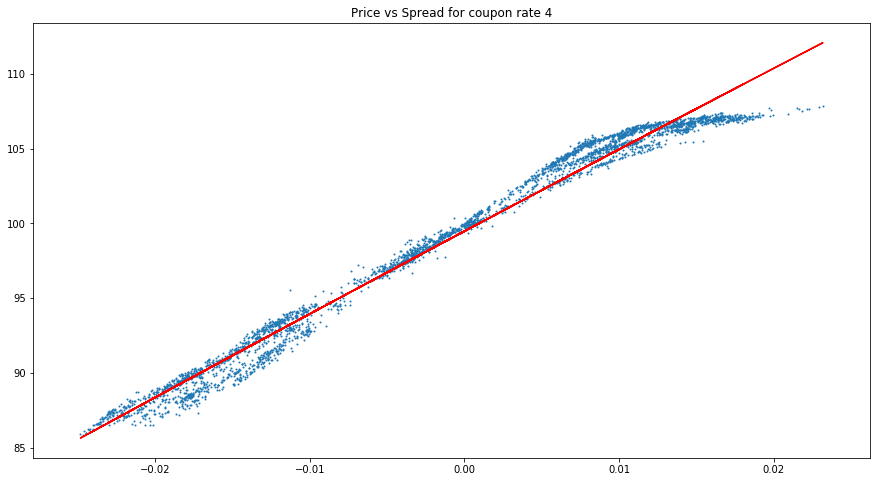

In [21]:
coupon=[4]

plt.figure(figsize=(15,8*len(coupon)))  
for k,c in enumerate(coupon):
    x=data['Spread'].values / 100
    y=data['price'].values
    data = TBAs[c]
    plt.subplot(len(coupon),1,k+1)
    plt.scatter(x, y,s=1)
    plt.title('Price vs Spread for coupon rate ' + str(c))
    
    fit, b = scipy.optimize.curve_fit(lambda t,a, b: a+b*np.exp(-t)+c*t*np.exp(-t), x,  y)
    a, b= fit[0], fit[1]
    plt.plot(x, a+b*np.exp(-x)+c*x*np.exp(-x),color='r')